# Guiding Customers Towards Product Subscription Through App Behavior Analysis
Imagine your company introduces an innovative app features. The first crucial step is finding customers. Offering a 24-hour free trial of the app can generate valuable user behavior data for marketing. This Capstone project aims to develop an ML model that classifies customers based on their app interactions.

Market: The target audience consists of customers who have downloaded the free version of our app services.

Product: The paid version offers enhanced features.

Goal: The objective of this Capstone project is to create a classification model that predicts which users are unlikely to subscribe to the paid membership, allowing for targeted marketing efforts. As a data scientist, my role is to identify users least likely to enroll in the paid version, to ensure efficient resource allocation. We assume that the free version access expires after 24 hours. 

The data utilized in this case study originates from a fintech company aiming to offer its customers a paid mobile app subscription, enabling them to conveniently manage all their finances in a single location.   

In [ ]:
# Tools needed to installed to google colab as they are not part of main tools installed by default
!pip install sweetviz # for intaractive report generation and visualization
# Tools for stat summary Table and feature selection
!pip install tableone
!pip install boruta
# Tool to get pdf file of Notebook
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [2]:
# file path tools
from google.colab import drive #for Connecting to Google Drive
from IPython.display import Image #for image display
# EDA tools
import pandas as pd # for data manipulation using dataframes
import numpy as np # for data statistical analysis 
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import seaborn as sns # Statistical data visualization
from dateutil import parser # to parse dates
%matplotlib inline
# Data preprocessing tools 
from tableone import TableOne # stat summary table 
from boruta import BorutaPy # for feature selection
from sklearn.ensemble import RandomForestClassifier #for feature selection
import sweetviz as sw #for interactive report generation

# Feature scaling, classification ML development and evaluation tools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import pickle
# System error handling tools
import warnings
warnings.filterwarnings('ignore')
print('Libraries Import Successful')

Libraries Import Successful


In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


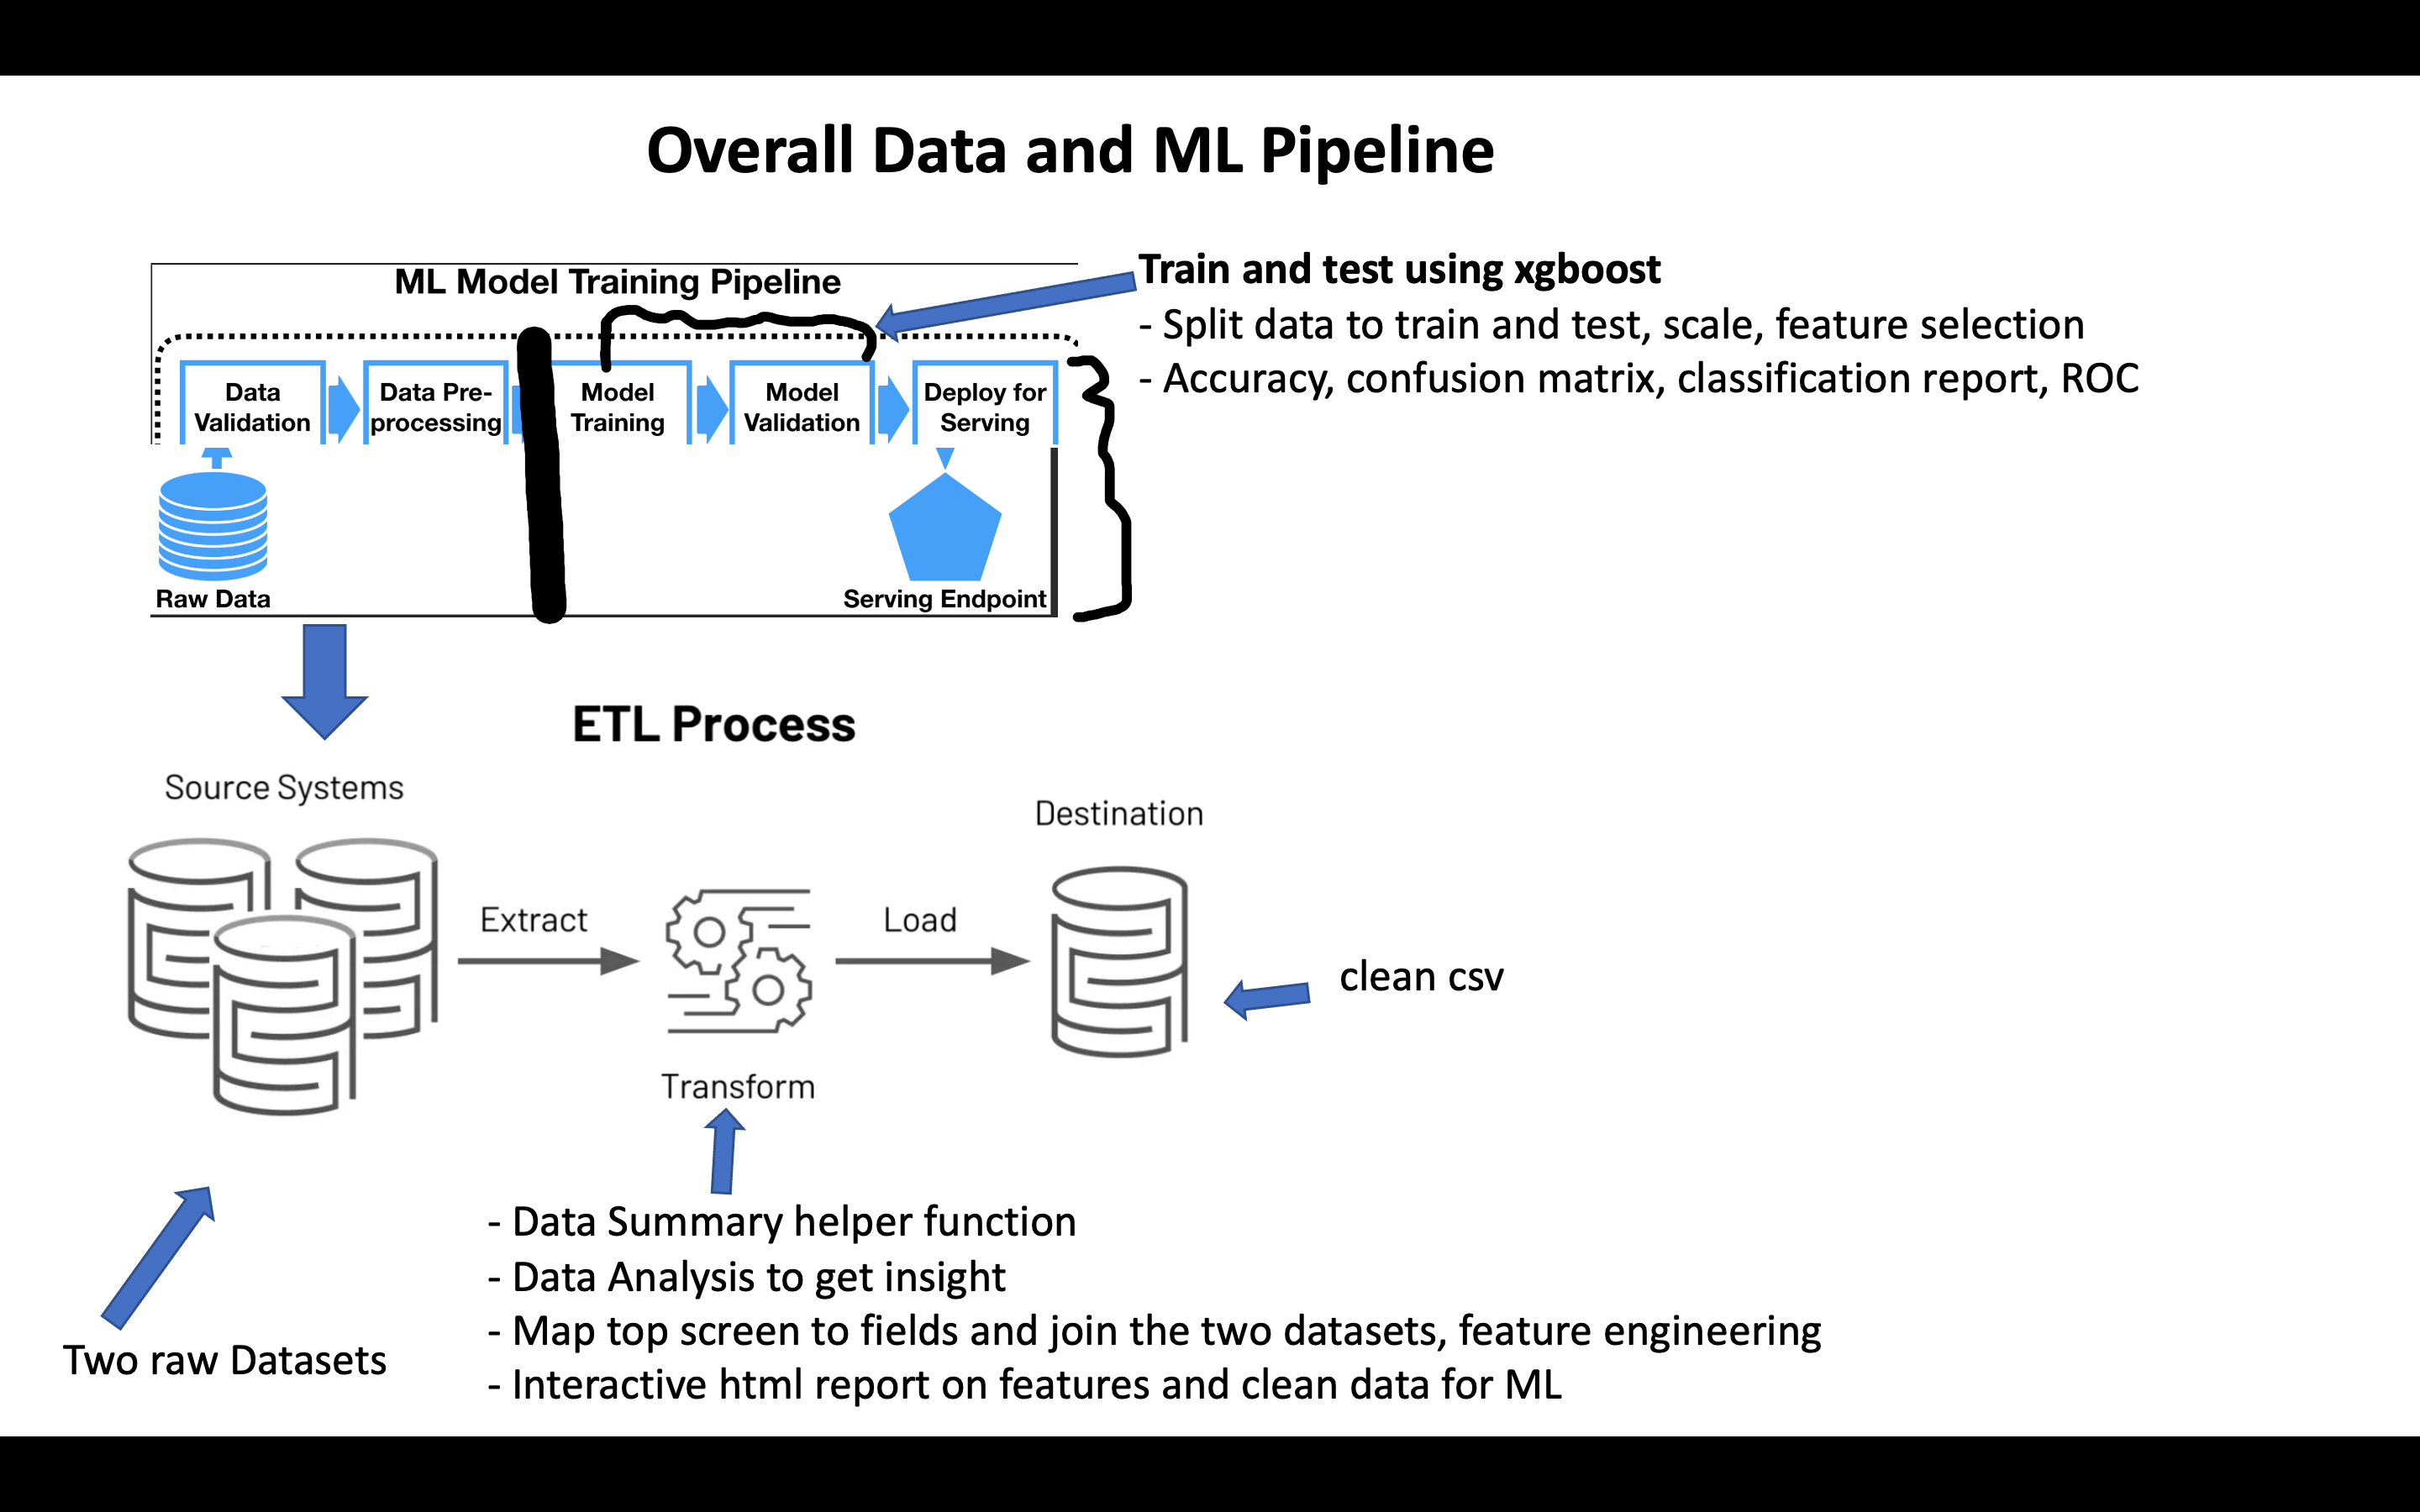

In [60]:
Image('/content/drive/MyDrive/Data_incubator/data_sets/adama_capstoneETL-ML-pipeline.png')

In [5]:
#importing data
dataset = pd.read_csv('/content/drive/MyDrive/Data_incubator/data_sets/appdata10.csv')
dataset.head(10)
# user is ID of each user (could be email)
#first_open is the day they first used the cancer classifier
#daysoftheweek (Sunday = 0 and Sat = 6)
#hour is time they first used the app
# screen_list is buttons (feature within app) they pushed within app
#numscreens is number of screen_list visited 
# minigame here it specific games they payed (0 means no play, 1 played)
#used_premium_feature if they tried paid version during free trial 0 = no, 1 = yes
#enrolled = 1 if the become member, 0 if not
#enrolled_date is when they become a member (it can be any time)
# like is whether or not they like the product

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1
5,56480,2013-04-03 09:58:15.752,2,09:00:00,20,"idscreen,Cycle,Home,ScanPreview,VerifyPhone,Ve...",14,0,0,1,2013-04-03 09:59:03.291,0
6,144649,2012-12-25 02:33:18.461,1,02:00:00,35,"product_review,product_review2,ScanPreview",3,0,0,0,NaN,0
7,249366,2012-12-11 03:07:49.875,1,03:00:00,26,"Splash,Cycle,Home,Credit3Container,Credit3Dash...",41,0,1,0,NaN,0
8,372004,2013-03-20 14:22:01.569,2,14:00:00,29,"product_review,product_review2,ScanPreview,Ver...",33,1,1,1,2013-04-27 22:24:54.542,0
9,338013,2013-04-26 18:22:16.013,4,18:00:00,26,"Home,Loan2,product_review,product_review,produ...",19,0,0,1,2013-04-26 18:31:58.923,0


In [58]:
dataset.columns

Index(['user', 'hour', 'age', 'numscreens', 'minigame', 'used_premium_feature',
       'location', 'Institutions', 'VerifyPhone', 'BankVerification',
       'VerifyDateOfBirth', 'ProfilePage', 'VerifyCountry', 'Cycle',
       'idscreen', 'Splash', 'Finances', 'Alerts', 'VerifyMobile',
       'VerifyHousing', 'VerifyHousingAmount', 'Rewards', 'AccountView',
       'VerifyAnnualIncome', 'Login', 'WebView', 'SecurityModal',
       'ResendToken', 'TransactionList', 'Other', 'SavingCount', 'CMCount',
       'CCCount', 'LoansCount'],
      dtype='object')

In [6]:
 # Function to find missing values ,unique values ,data types  --> EDA
def df_summary(df):
    df_U = df.nunique()
    df_M = df.isnull().sum()
    df_I = df.dtypes
    
    ## converting all data to dataframe
    df_U = df_U.to_frame().reset_index()
    df_M = df_M.to_frame().reset_index()
    df_I = df_I.to_frame().reset_index()
    
    ## renaming columns to default 0 to some sensible name
    df_U = df_U.rename(columns= {0: 'Unique Data'})
    df_M = df_M.rename(columns= {0: 'Missing Data'})
    df_I = df_I.rename(columns= {0: 'Data Types'})
    
    ## concatting the 3 dataframes. Remember pd.merge can merge only 2 df at a time
    output = pd.merge(pd.merge(df_M,df_U,on='index'),df_I,on='index')
    
    return output;  

In [7]:
df_summary(dataset)

,index,Missing Data,Unique Data,Data Types
0,user,0,49874,int64
1,first_open,0,49747,object
2,dayofweek,0,7,int64
3,hour,0,24,object
4,age,0,78,int64
5,screen_list,0,38799,object
6,numscreens,0,151,int64
7,minigame,0,2,int64
8,used_premium_feature,0,2,int64
9,enrolled,0,2,int64


In [8]:
dataset.describe()
# about 62 % enrolled; about 17 % liked 

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# First set of Feature cleaning
dataset['hour'] = dataset.hour.str.slice(1, 3).astype(int)  #to convert hour col to int, 1st and 2nd index of hour col, in python last index not included so 3 used 

In [10]:
dataset.describe()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,12.557220,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,7.438072,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,5.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,14.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,19.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,23.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# dropping less infomative, response valriable and non numeric columns to plot hostogram
dataset2 = dataset.copy().drop(columns = ['user', 'screen_list', 'enrolled_date',
                                           'first_open', 'enrolled'])
dataset2.head(10)

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1
5,2,9,20,14,0,0,0
6,1,2,35,3,0,0,0
7,1,3,26,41,0,1,0
8,2,14,29,33,1,1,0
9,4,18,26,19,0,0,0


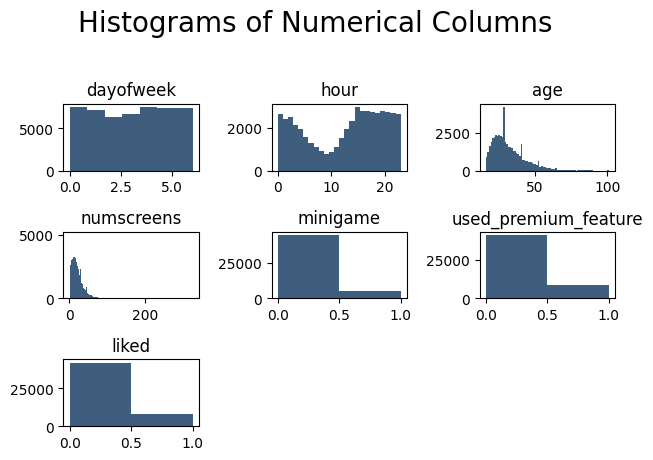

In [12]:
## Histograms to know data features distribution 
plt.suptitle('Histograms of Numerical Columns', fontsize=20)
for i in range(1, dataset2.shape[1] + 1): #dataset 2 shape + as last index is not included in python
    plt.subplot(3, 3, i) 
    f = plt.gca() #to print everything
#    f.axes.get_yaxis().set_visible(False)
    f.set_title(dataset2.columns.values[i - 1])

    vals = np.size(dataset2.iloc[:, i - 1].unique()) #to give bins based on data in its cols
    
    plt.hist(dataset2.iloc[:, i - 1], bins=vals, color='#3F5D7D')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig('app_data_hist.jpg')

# from hist things like alright. deep in hour col is late night, minigame, used_premium, liked are heavy to zero side. Meaning not many people used  

<Axes: title={'center': 'Correlation with Reposnse variable'}>

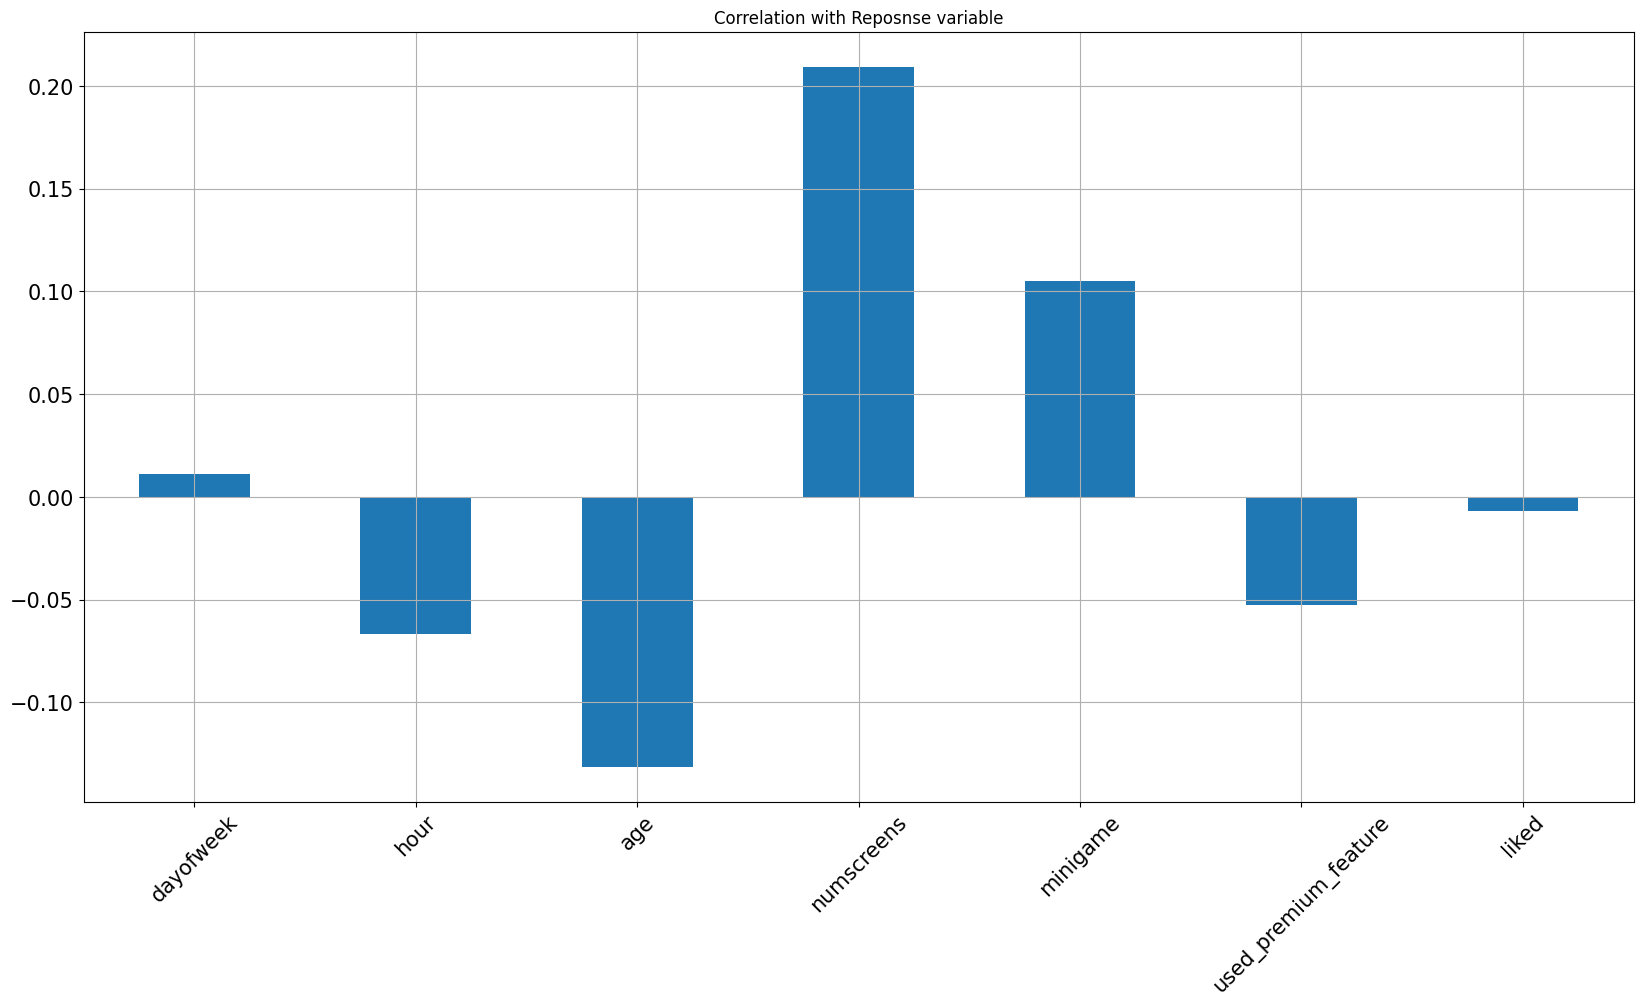

In [13]:
## Correlation with Response Variable
dataset2.corrwith(dataset.enrolled).plot.bar(figsize=(20,10),
                  title = 'Correlation with Reposnse variable',
                  fontsize = 15, rot = 45,
                  grid = True)

Note correlation plot: minigame and numscreens have +v correlation with respnse (enrolled) variable. The rest of freatures are in -ve correlation. 

<Axes: >

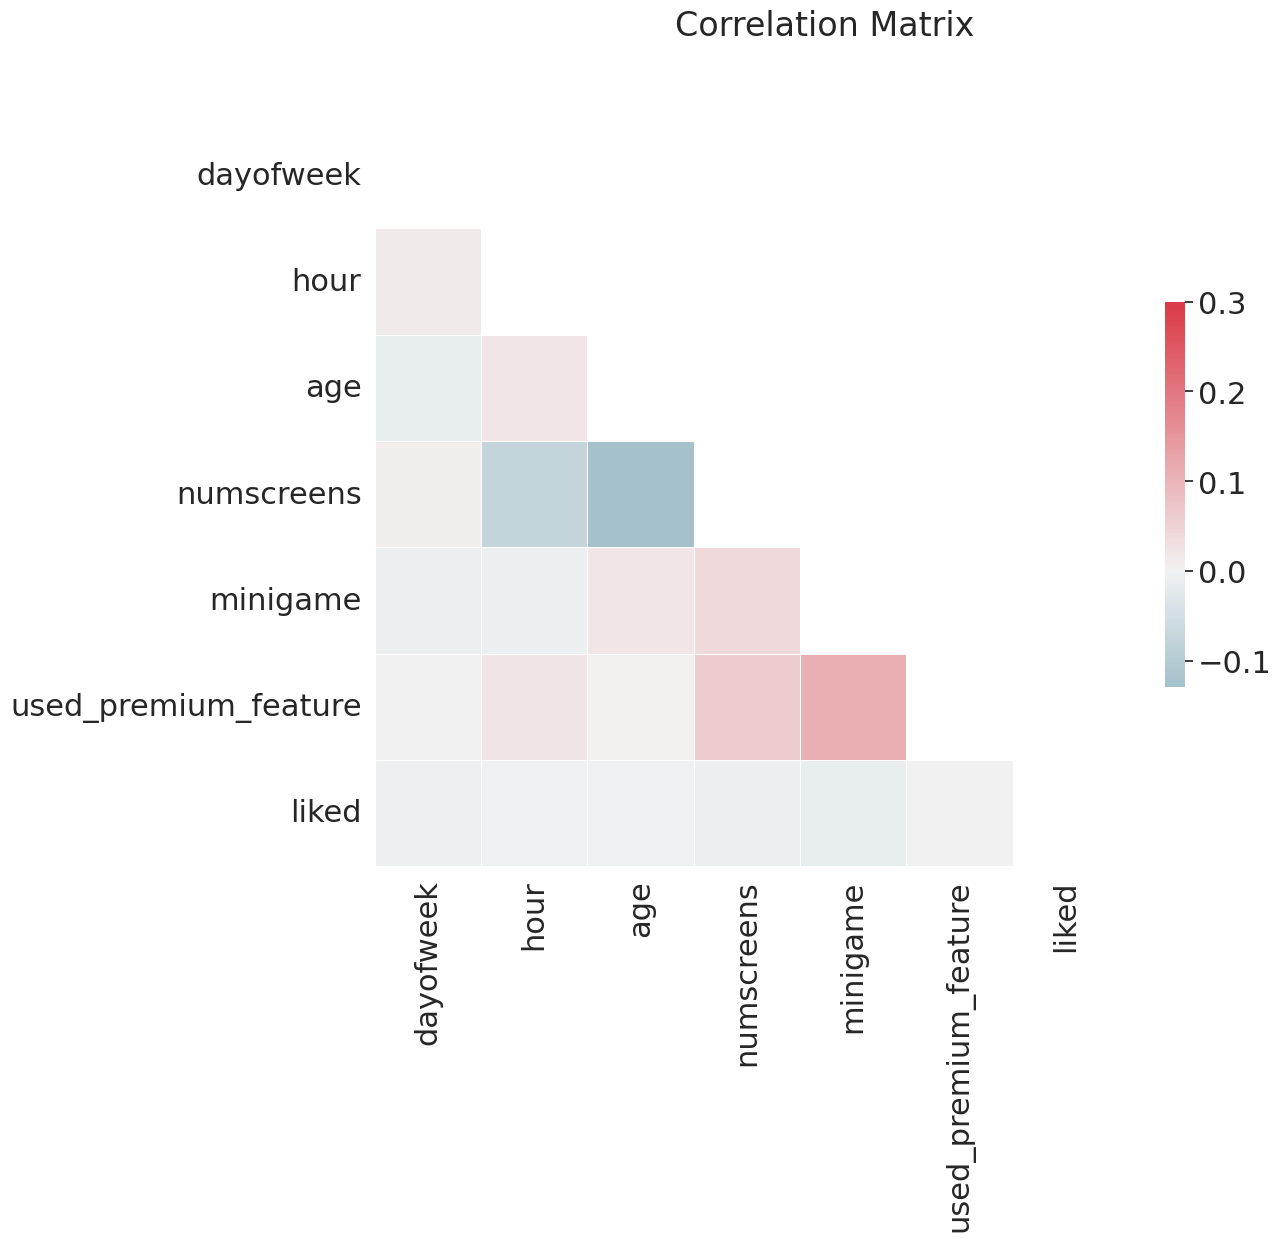

In [14]:
## When we build a model we assume that all features are independant. So we need to check that. There should be no feature that depend on the other. 
## Correlation Matrix
sns.set(style="white", font_scale=2)

# Compute the correlation matrix
corr = dataset2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
f.suptitle("Correlation Matrix", fontsize = 24)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Note from correlation metxrix: There is no intense (light blue i.e -ve correlation red i.e +ve correlation) observed. So we can all features are independent. age and numscreens have slight -ve correlation, used_premium_feature have slight +ve correlation. But nothing too intense in general. 

In [15]:
dataset.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                     int64
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

In [16]:
# Formatting Date Columns. We need to know how to evaluste our model. For this we need to know the difference between
# first_open and erolled so we know how our model perform by plotting the distribution. To do so we need to perse our date cols.
dataset["first_open"] = [parser.parse(row_date) for row_date in dataset["first_open"]] #row_date can be any thing, here we are converting to date time object; 
dataset["enrolled_date"] = [parser.parse(row_date) if isinstance(row_date, str) else row_date for row_date in dataset["enrolled_date"]] #if else is to apply only to str if not return row_data itseld
dataset.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int64
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

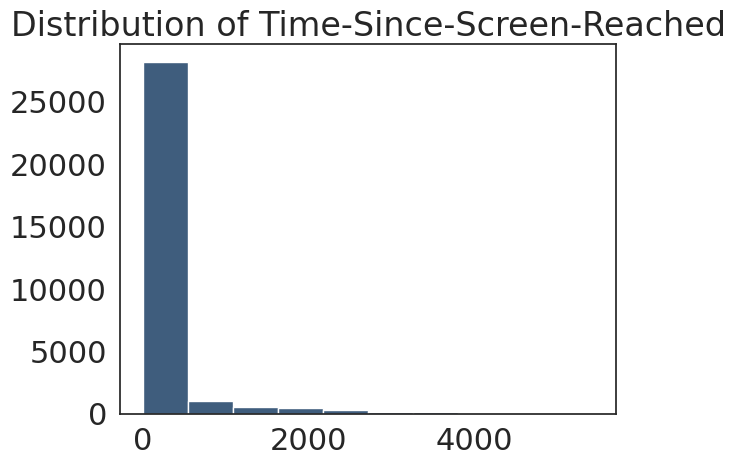

In [17]:
# Selecting Time For Response. Added column called difference by sutracting first_open from enrolled_date. timedelta64[h] is make time difference
# Most of the enrollemnt hapen in the first 500 hrs.
dataset["difference"] = (dataset.enrolled_date-dataset.first_open).astype('timedelta64[h]')
response_hist = plt.hist(dataset["difference"].dropna(), color='#3F5D7D')
plt.title('Distribution of Time-Since-Screen-Reached')
plt.show()

Note from above plot: Most people enrolled in the first 500 hours. Let us see what happen in the first 100 hours below. 

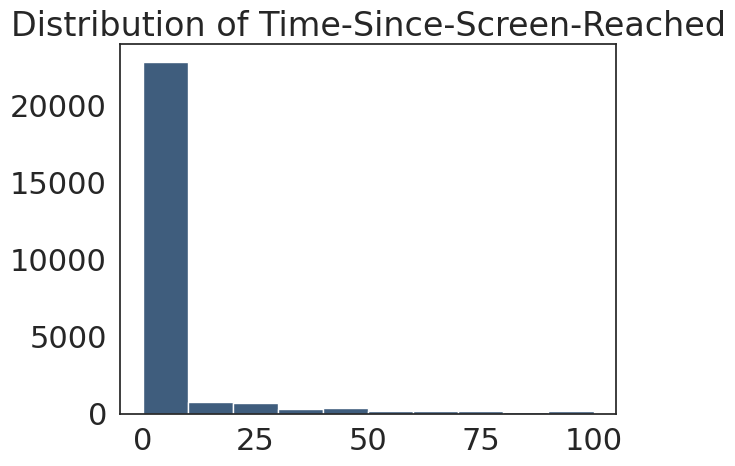

In [18]:
#modify to first 100 hours; indeed first 100 hour is even too long. so let us cut to 48 (two days) see below cell
plt.hist(dataset["difference"].dropna(), color='#3F5D7D', range = [0, 100])
plt.title('Distribution of Time-Since-Screen-Reached')
plt.show()

In [19]:
dataset.loc[dataset.difference > 48, 'enrolled'] = 0 # so 48 (two days) might be good cut, so  if not enrolled in 48 hrs we consider them as not enrolled (set to 0)
dataset = dataset.drop(columns=['enrolled_date', 'difference', 'first_open']) #remove cols we do not need anymore

In [20]:
dataset.head(10)

,user,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,liked
0,235136,3,2,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,0
1,333588,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0
2,254414,1,19,23,"Splash,Cycle,Loan",3,0,1,0,1
3,234192,4,16,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,0
4,51549,1,18,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,1
5,56480,2,9,20,"idscreen,Cycle,Home,ScanPreview,VerifyPhone,Ve...",14,0,0,1,0
6,144649,1,2,35,"product_review,product_review2,ScanPreview",3,0,0,0,0
7,249366,1,3,26,"Splash,Cycle,Home,Credit3Container,Credit3Dash...",41,0,1,0,0
8,372004,2,14,29,"product_review,product_review2,ScanPreview,Ver...",33,1,1,0,0
9,338013,4,18,26,"Home,Loan2,product_review,product_review,produ...",19,0,0,1,0


In [21]:
# Let load top screen data set. It is the top used screens
## Formatting the screen_list Field
## we had information regarding the to most used screens
# Load Top Screens
top_screens = pd.read_csv('/content/drive/MyDrive/Data_incubator/data_sets/top_screens.csv').top_screens.values # we select only values of top_sceens columns to have them as list
top_screens

array(['Loan2', 'location', 'Institutions', 'Credit3Container',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth',
       'ProfilePage', 'VerifyCountry', 'Cycle', 'idscreen',
       'Credit3Dashboard', 'Loan3', 'CC1Category', 'Splash', 'Loan',
       'CC1', 'RewardsContainer', 'Credit3', 'Credit1', 'EditProfile',
       'Credit2', 'Finances', 'CC3', 'Saving9', 'Saving1', 'Alerts',
       'Saving8', 'Saving10', 'Leaderboard', 'Saving4', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'Saving7', 'ProfileEducationMajor', 'Rewards', 'AccountView',
       'VerifyAnnualIncome', 'VerifyIncomeType', 'Saving2', 'Saving6',
       'Saving2Amount', 'Saving5', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'Loan4',
       'ResendToken', 'TransactionList', 'NetworkFailure', 'ListPicker'],
      dtype=object)

In [22]:
# Mapping Screens to Fields
dataset["screen_list"] = dataset.screen_list.astype(str) + ',' #to use comma to count or separate as many as number of screens

for sc in top_screens:
    dataset[sc] = dataset.screen_list.str.contains(sc).astype(int)
    dataset['screen_list'] = dataset.screen_list.str.replace(sc+",", "")

#for screens not in top_screens, we catagorized them to other col 
dataset['Other'] = dataset.screen_list.str.count(",")
dataset = dataset.drop(columns=['screen_list'])

In [23]:
dataset.head(10)

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,Loan2,...,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker,Other
0,235136,3,2,23,15,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,7
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,234192,4,16,28,40,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,6
4,51549,1,18,31,32,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,10
5,56480,2,9,20,14,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,6
6,144649,1,2,35,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
7,249366,1,3,26,41,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,8
8,372004,2,14,29,33,1,1,0,0,1,...,0,0,0,0,1,0,0,0,0,19
9,338013,4,18,26,19,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,11


In [24]:
# Funnels are screens that are related, by funneling we remove correlation but still keep their value. That is to remove highly similar (correlated screens)
savings_screens = ["Saving1",
                    "Saving2",
                    "Saving2Amount",
                    "Saving4",
                    "Saving5",
                    "Saving6",
                    "Saving7",
                    "Saving8",
                    "Saving9",
                    "Saving10"]
dataset["SavingCount"] = dataset[savings_screens].sum(axis=1)
dataset = dataset.drop(columns=savings_screens) #drop cols as they are already agregated to SavingCount col

cm_screens = ["Credit1",
               "Credit2",
               "Credit3",
               "Credit3Container",
               "Credit3Dashboard"]
dataset["CMCount"] = dataset[cm_screens].sum(axis=1)
dataset = dataset.drop(columns=cm_screens)

cc_screens = ["CC1",
                "CC1Category",
                "CC3"]
dataset["CCCount"] = dataset[cc_screens].sum(axis=1)
dataset = dataset.drop(columns=cc_screens)

loan_screens = ["Loan",
               "Loan2",
               "Loan3",
               "Loan4"]
dataset["LoansCount"] = dataset[loan_screens].sum(axis=1)
dataset = dataset.drop(columns=loan_screens)

#### Saving Results ####
dataset.head()
dataset.describe()
dataset.columns

dataset.to_csv('/content/drive/MyDrive/Data_incubator/data_sets/new_appdata10.csv', index = False) # this is clean data to be used

In [25]:
dataset.describe()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,SavingCount,CMCount,CCCount,LoansCount
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000
mean,186889.729900,3.029860,12.557220,31.72436,21.095900,0.107820,0.172020,0.497000,0.165000,0.517760,...,0.014220,0.013340,0.013400,0.008200,0.007580,6.214260,0.365020,0.92776,0.176860,0.788400
std,107768.520361,2.031997,7.438072,10.80331,15.728812,0.310156,0.377402,0.499996,0.371184,0.499689,...,0.118398,0.114727,0.114981,0.090183,0.086733,3.672561,1.405511,1.21751,0.612787,0.677462
min,13.000000,0.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,93526.750000,1.000000,5.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.00000,0.000000,0.000000
50%,187193.500000,3.000000,14.000000,29.00000,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.00000,0.000000,1.000000
75%,279984.250000,5.000000,19.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.00000,0.000000,1.000000
max,373662.000000,6.000000,23.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,10.000000,5.00000,3.000000,3.000000


In [26]:
dataset.columns

Index(['user', 'dayofweek', 'hour', 'age', 'numscreens', 'minigame',
       'used_premium_feature', 'enrolled', 'liked', 'location', 'Institutions',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth', 'ProfilePage',
       'VerifyCountry', 'Cycle', 'idscreen', 'Splash', 'RewardsContainer',
       'EditProfile', 'Finances', 'Alerts', 'Leaderboard', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'ProfileEducationMajor', 'Rewards', 'AccountView', 'VerifyAnnualIncome',
       'VerifyIncomeType', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'ResendToken',
       'TransactionList', 'NetworkFailure', 'ListPicker', 'Other',
       'SavingCount', 'CMCount', 'CCCount', 'LoansCount'],
      dtype='object')

# Data Pre-processing 

In [27]:
# Load the clean saved data
dataset = pd.read_csv('/content/drive/MyDrive/Data_incubator/data_sets/new_appdata10.csv')
display(dataset.shape)
display(dataset.head(10))
display(dataset.tail(10))

(50000, 50)

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,SavingCount,CMCount,CCCount,LoansCount
0,235136,3,2,23,15,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,1
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,5,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,234192,4,16,28,40,0,0,1,0,1,...,0,0,0,0,0,6,0,3,0,1
4,51549,1,18,31,32,0,0,1,1,0,...,0,0,0,0,0,10,0,2,0,1
5,56480,2,9,20,14,0,0,1,0,0,...,0,0,0,0,0,6,0,2,0,1
6,144649,1,2,35,3,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
7,249366,1,3,26,41,0,1,0,0,0,...,0,0,1,0,0,8,0,2,0,1
8,372004,2,14,29,33,1,1,0,0,1,...,0,0,0,0,0,19,0,0,0,3
9,338013,4,18,26,19,0,0,1,0,1,...,0,0,0,0,0,11,0,0,0,1


,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,SavingCount,CMCount,CCCount,LoansCount
49990,179308,5,17,20,8,0,0,1,1,0,...,0,0,0,0,0,4,0,0,0,0
49991,85532,4,22,45,30,1,1,1,0,1,...,0,0,0,0,0,3,0,3,0,2
49992,96155,6,15,50,28,0,0,1,0,1,...,1,0,0,0,0,9,0,1,0,1
49993,343026,5,2,28,4,0,0,0,1,0,...,0,0,0,0,0,4,0,0,0,0
49994,90813,0,19,36,25,0,0,1,0,1,...,0,0,1,0,0,9,0,0,0,1
49995,222774,3,13,32,13,0,0,1,0,0,...,0,0,0,0,0,6,0,2,0,0
49996,169179,1,0,35,4,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
49997,302367,2,22,39,25,0,0,0,0,1,...,0,0,0,0,0,6,0,0,0,0
49998,324905,6,12,27,26,0,0,1,0,1,...,0,0,0,0,0,13,0,0,0,0
49999,27047,4,1,25,26,0,0,0,1,0,...,0,0,0,0,0,5,7,0,0,1


In [28]:
df_summary(dataset)

,index,Missing Data,Unique Data,Data Types
0,user,0,49874,int64
1,dayofweek,0,7,int64
2,hour,0,24,int64
3,age,0,78,int64
4,numscreens,0,151,int64
5,minigame,0,2,int64
6,used_premium_feature,0,2,int64
7,enrolled,0,2,int64
8,liked,0,2,int64
9,location,0,2,int64


## STEP # 3: Feature selection using Boruta 
### Why Feature selection?
1. Mitigates overfitting
2. Lowers cost
3. Reduces errors

**Boruta** is wrapper method that select relevant features. It eliminate arbitrary cutoff criterion. Features compared to stochastic realization of themselves; not to each other.   

Let's address the warnings raised by the table 1 above and see if we have to reformat some of the features.

### Addressing the warnings
Let's have a look at the disributions for those features that appeared in the warnings.

In [30]:
# Generate table 1, group by last column (target)
TableOne(dataset, groupby=dataset.columns[-1],
         pval=True,
         dip_test=True,
         normal_test=True,
         tukey_test=True)

Grouped by LoansCount                                                                                                                 
                                                 Missing              Overall                    0                    1                    2                    3 P-Value
n                                                                       50000                17229                26776                 5341                  654        
user, mean (SD)                                        0  186889.7 (107768.5)  187453.4 (107611.0)  186245.1 (107772.4)  187615.0 (108063.6)  192511.5 (109298.7)   0.327
dayofweek, n (%)               0                       0          7515 (15.0)          2568 (14.9)          3998 (14.9)           846 (15.8)           103 (15.7)  <0.001
                               1                                  7139 (14.3)          2453 (14.2)          3815 (14.2)           777 (14.5)            94 (14.4)        
                               2                                  6315 (12.6)          2241 (13.0)          3379 (12.6)           611 (11.4)            84 (12.8)        
                               3                                  6659 (13.3)          2485 (14.4)          3541 (13.2)           547 (10.2)            86 (13.1)        
                               4                                  7531 (15.1)          2523 (14.6)          4002 (14.9)           911 (17.1)            95 (14.5)        
                               5                                  7423 (14.8)          2413 (14.0)          4055 (15.1)           863 (16.2)            92 (14.1)        
                               6                                  7418 (14.8)          2546 (14.8)          3986 (14.9)           786 (14.7)           100 (15.3)        
hour, n (%)                    0                       0           2666 (5.3)            796 (4.6)           1523 (5.7)            297 (5.6)             50 (7.6)  <0.001
                               1                                   2438 (4.9)            767 (4.5)           1395 (5.2)            237 (4.4)             39 (6.0)        
                               10                                   849 (1.7)            303 (1.8)            478 (1.8)             60 (1.1)              8 (1.2)        
                               11                                  1111 (2.2)            446 (2.6)            552 (2.1)            100 (1.9)             13 (2.0)        
                               12                                  1511 (3.0)            485 (2.8)            845 (3.2)            160 (3.0)             21 (3.2)        
                               13                                  1946 (3.9)            762 (4.4)            975 (3.6)            185 (3.5)             24 (3.7)        
                               14                                  2309 (4.6)            737 (4.3)           1276 (4.8)            264 (4.9)             32 (4.9)        
                               15                                  2989 (6.0)           1062 (6.2)           1473 (5.5)            409 (7.7)             45 (6.9)        
                               16                                  2790 (5.6)            843 (4.9)           1552 (5.8)            349 (6.5)             46 (7.0)        
                               17                                  2811 (5.6)           1071 (6.2)           1374 (5.1)            341 (6.4)             25 (3.8)        
                               18                                  2729 (5.5)            874 (5.1)           1485 (5.5)            331 (6.2)             39 (6.0)        
                               19                                  2708 (5.4)           1024 (5.9)           1354 (5.1)            289 (5.4)             41 (6.3)        
                               2                                   2503 (5.0)            852 (4.9)           1372 (5.1)      

In [31]:
#80-20 partition
df_test = dataset.sample(frac=0.2)
df_train = dataset.drop(df_test.index)
display(df_train.shape)
display(df_test.shape)

(40000, 50)

(10000, 50)

In [32]:
# get predictors and labels
X = np.array(df_train.drop('enrolled', axis=1)) 
y = np.array(df_train['enrolled'])

# define random forest classifier for boruta
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=3)
# forest.fit(X, y) bc no need to fit

# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=0, random_state=42)

# find all relevant features
feat_selector.fit(X, y)

# zip by names, ranks, and decisions in a single iterable
feature_ranks = list(zip(dataset.columns.drop('enrolled'), 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    display('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

'Feature: user                      Rank: 4,  Keep: False'

'Feature: dayofweek                 Rank: 7,  Keep: False'

'Feature: hour                      Rank: 1,  Keep: True'

'Feature: age                       Rank: 1,  Keep: True'

'Feature: numscreens                Rank: 1,  Keep: True'

'Feature: minigame                  Rank: 1,  Keep: True'

'Feature: used_premium_feature      Rank: 1,  Keep: True'

'Feature: liked                     Rank: 16,  Keep: False'

'Feature: location                  Rank: 1,  Keep: True'

'Feature: Institutions              Rank: 1,  Keep: True'

'Feature: VerifyPhone               Rank: 1,  Keep: True'

'Feature: BankVerification          Rank: 1,  Keep: True'

'Feature: VerifyDateOfBirth         Rank: 1,  Keep: True'

'Feature: ProfilePage               Rank: 1,  Keep: True'

'Feature: VerifyCountry             Rank: 1,  Keep: True'

'Feature: Cycle                     Rank: 1,  Keep: True'

'Feature: idscreen                  Rank: 1,  Keep: True'

'Feature: Splash                    Rank: 1,  Keep: True'

'Feature: RewardsContainer          Rank: 7,  Keep: False'

'Feature: EditProfile               Rank: 10,  Keep: False'

'Feature: Finances                  Rank: 1,  Keep: True'

'Feature: Alerts                    Rank: 1,  Keep: True'

'Feature: Leaderboard               Rank: 13,  Keep: False'

'Feature: VerifyMobile              Rank: 1,  Keep: True'

'Feature: VerifyHousing             Rank: 1,  Keep: True'

'Feature: RewardDetail              Rank: 3,  Keep: False'

'Feature: VerifyHousingAmount       Rank: 1,  Keep: True'

'Feature: ProfileMaritalStatus      Rank: 2,  Keep: False'

'Feature: ProfileChildren           Rank: 17,  Keep: False'

'Feature: ProfileEducation          Rank: 7,  Keep: False'

'Feature: ProfileEducationMajor     Rank: 7,  Keep: False'

'Feature: Rewards                   Rank: 1,  Keep: True'

'Feature: AccountView               Rank: 1,  Keep: True'

'Feature: VerifyAnnualIncome        Rank: 1,  Keep: True'

'Feature: VerifyIncomeType          Rank: 5,  Keep: False'

'Feature: ProfileJobTitle           Rank: 11,  Keep: False'

'Feature: Login                     Rank: 1,  Keep: True'

'Feature: ProfileEmploymentLength   Rank: 12,  Keep: False'

'Feature: WebView                   Rank: 1,  Keep: True'

'Feature: SecurityModal             Rank: 1,  Keep: True'

'Feature: ResendToken               Rank: 1,  Keep: True'

'Feature: TransactionList           Rank: 1,  Keep: True'

'Feature: NetworkFailure            Rank: 15,  Keep: False'

'Feature: ListPicker                Rank: 14,  Keep: False'

'Feature: Other                     Rank: 1,  Keep: True'

'Feature: SavingCount               Rank: 1,  Keep: True'

'Feature: CMCount                   Rank: 1,  Keep: True'

'Feature: CCCount                   Rank: 1,  Keep: True'

'Feature: LoansCount                Rank: 1,  Keep: True'

### Note: Boruta recommend keeping all the informative features. But five features 'mean fractal dimension', 'texture error', 'smoothness error', 'symmetry error', 'fractal dimension error' are less less infomative and was removed. 

In [33]:
dataset.columns

Index(['user', 'dayofweek', 'hour', 'age', 'numscreens', 'minigame',
       'used_premium_feature', 'enrolled', 'liked', 'location', 'Institutions',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth', 'ProfilePage',
       'VerifyCountry', 'Cycle', 'idscreen', 'Splash', 'RewardsContainer',
       'EditProfile', 'Finances', 'Alerts', 'Leaderboard', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'ProfileEducationMajor', 'Rewards', 'AccountView', 'VerifyAnnualIncome',
       'VerifyIncomeType', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'ResendToken',
       'TransactionList', 'NetworkFailure', 'ListPicker', 'Other',
       'SavingCount', 'CMCount', 'CCCount', 'LoansCount'],
      dtype='object')

In [34]:
dataset = dataset.drop(['dayofweek', 'liked', 'RewardsContainer', 'EditProfile', 'Leaderboard', 'RewardDetail', 'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation', 'ProfileEducationMajor', 'VerifyIncomeType', 'ProfileJobTitle', 'ProfileEmploymentLength', 'NetworkFailure', 'ListPicker'], axis =1)
dataset.columns

Index(['user', 'hour', 'age', 'numscreens', 'minigame', 'used_premium_feature',
       'enrolled', 'location', 'Institutions', 'VerifyPhone',
       'BankVerification', 'VerifyDateOfBirth', 'ProfilePage', 'VerifyCountry',
       'Cycle', 'idscreen', 'Splash', 'Finances', 'Alerts', 'VerifyMobile',
       'VerifyHousing', 'VerifyHousingAmount', 'Rewards', 'AccountView',
       'VerifyAnnualIncome', 'Login', 'WebView', 'SecurityModal',
       'ResendToken', 'TransactionList', 'Other', 'SavingCount', 'CMCount',
       'CCCount', 'LoansCount'],
      dtype='object')

In [63]:
dataset.to_csv('/content/drive/MyDrive/Data_incubator/data_sets/new_engineeredFinal_appdata10.csv', index = False)

In [36]:
analyze_report = sw.analyze(dataset)
analyze_report.show_html('/content/drive/MyDrive/Data_incubator/cb_EDA_output.htm', open_browser = True)

                                             |          | [  0%]   00:00 -> (? left)

Report /content/drive/MyDrive/Data_incubator/cb_EDA_output.htm was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Step 4: Feature scaling and Train test split

In [37]:
# Splitting Independent and Response Variables
response = dataset["enrolled"]
dataset = dataset.drop(columns="enrolled")

# Splitting the dataset into the Training set and Test set, ub stands for user behaivor
#from sklearn.model_selection import train_test_split
X_trainub, X_testub, y_trainub, y_testub = train_test_split(dataset, response,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [38]:
# Removing Identifiers form both train and test feature, but save them so when the model is done we can relate it back
train_identity = X_trainub['user']
X_trainub = X_trainub.drop(columns = ['user'])
test_identity = X_testub['user']
X_testub = X_testub.drop(columns = ['user'])

In [39]:
# Feature Scaling
#we do this to avoid that a given feature has great influence on the model just because its absolute value is big
#from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
#when standardization done the data we loose cols and index, we use pd.DataFrame to avoid that
X_trainub2 = pd.DataFrame(sc_X.fit_transform(X_trainub))  
X_testub2 = pd.DataFrame(sc_X.transform(X_testub)) #Note no fit here as fit is done when fitting the training set
X_trainub2.columns = X_trainub.columns.values #get original cols
X_testub2.columns = X_testub.columns.values
X_trainub2.index = X_trainub.index.values #to recuperate original index
X_testub2.index = X_testub.index.values
X_trainub = X_trainub2
X_testub = X_testub2

In [40]:
dataset_final = pd.read_csv('/content/drive/MyDrive/Data_incubator/data_sets/new_engineeredFinal_appdata10.csv')
dataset_final.head(10)

,user,hour,age,numscreens,minigame,used_premium_feature,enrolled,location,Institutions,VerifyPhone,...,Login,WebView,SecurityModal,ResendToken,TransactionList,Other,SavingCount,CMCount,CCCount,LoansCount
0,235136,2,23,15,0,0,0,0,0,1,...,1,0,0,0,0,7,0,0,0,1
1,333588,1,24,13,0,0,0,1,1,1,...,0,0,0,0,0,5,0,0,0,1
2,254414,19,23,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,234192,16,28,40,0,0,1,1,0,1,...,0,0,0,0,0,6,0,3,0,1
4,51549,18,31,32,0,0,1,0,1,1,...,0,0,0,0,0,10,0,2,0,1
5,56480,9,20,14,0,0,1,0,1,1,...,0,0,0,0,0,6,0,2,0,1
6,144649,2,35,3,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
7,249366,3,26,41,0,1,0,0,0,1,...,0,0,0,0,1,8,0,2,0,1
8,372004,14,29,33,1,1,0,1,1,1,...,0,0,0,0,0,19,0,0,0,3
9,338013,18,26,19,0,0,1,1,0,1,...,0,0,0,0,0,11,0,0,0,1


In [41]:
df_summary(dataset_final)

,index,Missing Data,Unique Data,Data Types
0,user,0,49874,int64
1,hour,0,24,int64
2,age,0,78,int64
3,numscreens,0,151,int64
4,minigame,0,2,int64
5,used_premium_feature,0,2,int64
6,enrolled,0,2,int64
7,location,0,2,int64
8,Institutions,0,2,int64
9,VerifyPhone,0,2,int64


In [42]:
dataset_final.columns

Index(['user', 'hour', 'age', 'numscreens', 'minigame', 'used_premium_feature',
       'enrolled', 'location', 'Institutions', 'VerifyPhone',
       'BankVerification', 'VerifyDateOfBirth', 'ProfilePage', 'VerifyCountry',
       'Cycle', 'idscreen', 'Splash', 'Finances', 'Alerts', 'VerifyMobile',
       'VerifyHousing', 'VerifyHousingAmount', 'Rewards', 'AccountView',
       'VerifyAnnualIncome', 'Login', 'WebView', 'SecurityModal',
       'ResendToken', 'TransactionList', 'Other', 'SavingCount', 'CMCount',
       'CCCount', 'LoansCount'],
      dtype='object')

In [43]:
# Splitting Independent and Response Variables
response = dataset_final["enrolled"]
dataset_final = dataset_final.drop(columns="enrolled")

# Splitting the dataset into the Training set and Test set, ub stands for user behaivor
#from sklearn.model_selection import train_test_split
X_trainub, X_testub, y_trainub, y_testub = train_test_split(dataset_final, response,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [44]:
# Removing Identifiers form both train and test feature, but save them so when the model is done we can relate it back
train_identity = X_trainub['user']
X_trainub = X_trainub.drop(columns = ['user'])
test_identity = X_testub['user']
X_testub = X_testub.drop(columns = ['user'])

In [45]:
# Feature Scaling
#we do this to avoid that a given feature has great influence on the model just because its absolute value is big
#from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
#when standardization done the data we loose cols and index, we use pd.DataFrame to avoid that
X_trainub2 = pd.DataFrame(sc_X.fit_transform(X_trainub))  
X_testub2 = pd.DataFrame(sc_X.transform(X_testub)) #Note no fit here as fit is done when fitting the training set
X_trainub2.columns = X_trainub.columns.values #get original cols
X_testub2.columns = X_testub.columns.values
X_trainub2.index = X_trainub.index.values #to recuperate original index
X_testub2.index = X_testub.index.values
X_trainub = X_trainub2
X_testub = X_testub2

xgb Confusion Matrix:
[[4117  988]
 [1224 3671]]
---------------------------------------------------------------
xgb Accuracy:  0.7788
---------------------------------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      5105
           1       0.79      0.75      0.77      4895

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

---------------------------------------------------------------
XGBClassifier Confusion Matrix heatmap:


<Axes: >

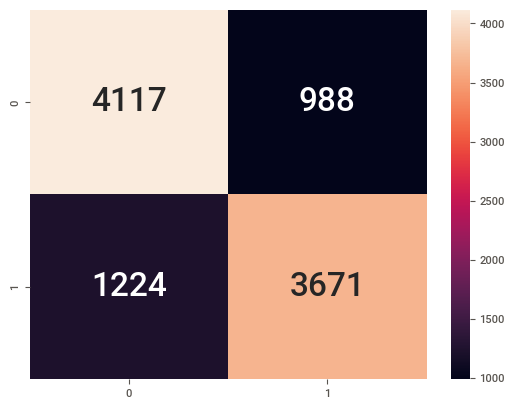

In [46]:
xgb_classifier = XGBClassifier(colsample_bylevel=0.9, colsample_bytree=0.9, importance_type='gain', learning_rate=0.01, max_depth=4, n_estimators=200, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0, random_state=0)
xgb_classifier.fit(X_trainub, y_trainub)
xgb_y_pred = xgb_classifier.predict(X_testub)
xgb_cm = confusion_matrix(y_testub, xgb_y_pred)
print('xgb Confusion Matrix:')
print(xgb_cm)
print("---------------------------------------------------------------")
print('xgb Accuracy: ', accuracy_score(y_testub, xgb_y_pred))
print("---------------------------------------------------------------")
print("classification report")
print(classification_report(y_testub, xgb_y_pred))
print("---------------------------------------------------------------")
print('XGBClassifier Confusion Matrix heatmap:')
sns.heatmap(xgb_cm, annot=True, fmt="d")

In [47]:
r_probs = [0 for _ in range(len(y_testub))]
rf_probs = xgb_classifier.predict_proba(X_testub)

In [48]:
# Probabilities for the positive outcome is kept.
rf_probs = rf_probs[:, 1]

In [50]:
r_auc = roc_auc_score(y_testub, r_probs)
rf_auc = roc_auc_score(y_testub, rf_probs)

#Print AUROC scores
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('gb Customer Behavior: AUROC = %.3f' % (rf_auc))

Random (chance) Prediction: AUROC = 0.500
gb Customer Behavior: AUROC = 0.852


In [51]:
#Calculate ROC curve
r_fpr, r_tpr, _ = roc_curve(y_testub, r_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_testub, rf_probs)

## Plot the ROC curve

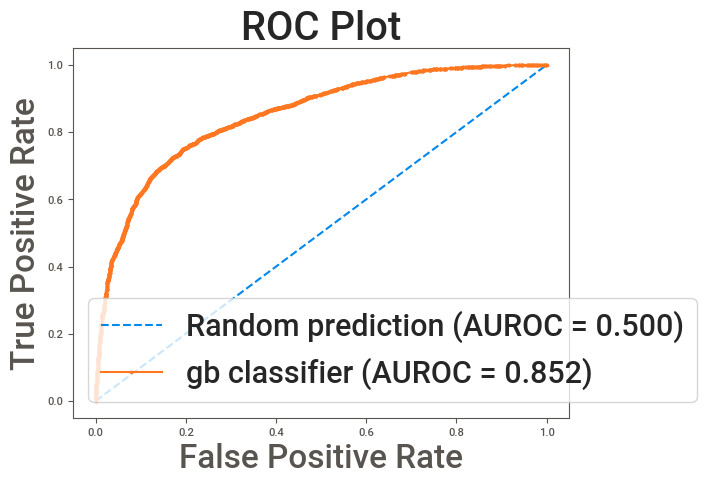

In [52]:
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='gb classifier (AUROC = %0.3f)' % rf_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# The ML model developed here classifies customers into easily subscribers and hard to engage with 79 % Accuracy! This model can aid marketing team to target those custmers with hard to engage behaviors. 

In [54]:
# Formatting Final Results
final_results_XB = pd.concat([y_testub, test_identity], axis = 1).dropna()
final_results_XB['predicted_reach'] = xgb_y_pred
final_results_XB = final_results_XB[['user', 'enrolled', 'predicted_reach']].reset_index(drop=True)

In [ ]:
final_results_XB

,user,enrolled,predicted_reach
0,48024,1,0
1,266463,1,0
2,262169,1,0
3,213736,1,0
4,169082,1,1
...,...,...,...
9995,367119,0,1
9996,4433,0,0
9997,146917,1,1
9998,77281,1,1


In [55]:
# final prediction for marketing team. Model predcition and Customer ID recombined
final_results_XB.to_csv('/content/drive/MyDrive/Data_incubator/data_sets/final_predictionXB_forMarketingTeam.csv', index = False) # this is clean prediction to be used by marketing team to target the customers

In [56]:
# Save the model in pickle file
pickle.dump(xgb_classifier, open("/content/drive/MyDrive/Data_incubator/data_sets/customer_behaver_predictor.pkl","wb"))

In [61]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/Data_incubator/Adama_Capstone_project_final.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Data_incubator/Adama_Capstone_project_final.ipynb to pdf
[NbConvertApp] Support files will be in Adama_Capstone_project_final_files/
[NbConvertApp] Making directory ./Adama_Capstone_project_final_files
[NbConvertApp] Making directory ./Adama_Capstone_project_final_files
[NbConvertApp] Making directory ./Adama_Capstone_project_final_files
[NbConvertApp] Making directory ./Adama_Capstone_project_final_files
[NbConvertApp] Making directory ./Adama_Capstone_project_final_files
[NbConvertApp] Making directory ./Adama_Capstone_project_final_files
[NbConvertApp] Making directory ./Adama_Capstone_project_final_files
[NbConvertApp] Making directory ./Adama_Capstone_project_final_files
[NbConvertApp] Writing 189622 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had pr